In [1]:
import numpy as np 
import pandas as pd 

import json
import time
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import itertools

#from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', 'input', 'output', 'Assignment-1.pdf', '.ipynb_checkpoints', 'electricity-demand-prediction.ipynb']


In [2]:
column_names = ['load_demand']
#house_data = pd.read_csv("./input/" + in_file_name, low_memory=False, nrows=None, names=column_names)
all_house_data = []
for houseid in range(1,11):
    in_file_name = "Home"+str(houseid)+"_yr1.csv"
    house_data = pd.read_csv("./input/" + in_file_name, low_memory=False, nrows=None, names=column_names)
    #print(house_data.describe())
    all_house_data.append(house_data)

In [3]:
all_house_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 1 columns):
load_demand    35040 non-null float64
dtypes: float64(1)
memory usage: 273.8 KB


In [4]:
all_house_data[0].describe()

,load_demand
count,35040.000000
mean,1.327208
std,1.399019
min,0.015124
25%,0.315678
50%,0.722875
75%,1.988425
max,15.500000


In [5]:

epochTime = 1417392000

def get_time_stamp(row):
    global epochTime
    epochTime+=900
    return pd.to_datetime(epochTime,unit='s')

for house_data in all_house_data:
    house_data['time_stamp'] = house_data.apply (lambda row: get_time_stamp(row),axis=1)

In [6]:
#all_house_data[0].head(10)
all_house_data[0].describe

<bound method NDFrame.describe of        load_demand          time_stamp
0          0.65018 2014-12-01 00:15:00
1          1.45400 2014-12-01 00:30:00
2          0.72971 2014-12-01 00:45:00
3          3.10750 2014-12-01 01:00:00
4          0.63572 2014-12-01 01:15:00
5          0.69720 2014-12-01 01:30:00
6          1.50610 2014-12-01 01:45:00
7          0.85858 2014-12-01 02:00:00
8          1.61320 2014-12-01 02:15:00
9          0.66075 2014-12-01 02:30:00
10         0.50952 2014-12-01 02:45:00
11         1.53310 2014-12-01 03:00:00
12         0.64315 2014-12-01 03:15:00
13         1.55420 2014-12-01 03:30:00
14         0.63596 2014-12-01 03:45:00
15         1.12640 2014-12-01 04:00:00
16         0.94811 2014-12-01 04:15:00
17         0.94247 2014-12-01 04:30:00
18         1.03720 2014-12-01 04:45:00
19         1.17440 2014-12-01 05:00:00
20         0.87564 2014-12-01 05:15:00
21         2.68930 2014-12-01 05:30:00
22         0.82416 2014-12-01 05:45:00
23         1.33590 2014-12-01 

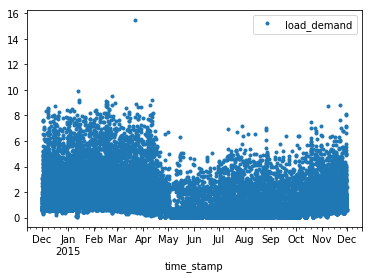

In [7]:
all_house_data[0].plot('time_stamp', 'load_demand', style=".")

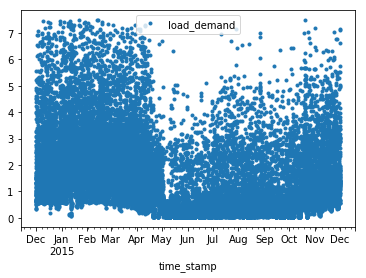

In [8]:
mean = all_house_data[0].loc[all_house_data[0]['load_demand']<7.5, 'load_demand'].mean()
all_house_data[0]["load_demand"] = np.where(all_house_data[0]["load_demand"] >=7.5, mean, all_house_data[0]['load_demand'])
all_house_data[0].plot('time_stamp', 'load_demand', style=".")

In [9]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-12-01', end='2015-11-30').to_pydatetime()

#get hour:minute format
def hour_minute(row_data):
    return (row_data.time_stamp.hour) #* 100 + (row_data.pickup_datetime.minute)

#get day_of_week format
def day_of_week(row_data):
    return (row_data.time_stamp.weekday())

def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.time_stamp)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0

#get month format
def get_month(row_data):
    return (row_data.time_stamp.month)


for house_data in all_house_data:
    house_data['time_of_day'] = house_data.apply(lambda row: hour_minute(row), axis=1)
    house_data['day_of_week'] = house_data.apply(lambda row: day_of_week(row), axis=1)
    house_data['holiday'] = house_data.apply(lambda row: check_holiday(row), axis=1)
    house_data['month_of_year'] = house_data.apply(lambda row: get_month(row), axis=1)
    house_data['slot'] = np.array([i for i in range(1,len(house_data)+1)]).reshape(-1, 1)
    house_data_copy = house_data.copy()
    #del house_data['time_stamp']

all_house_data[0].head(10)

,load_demand,time_stamp,time_of_day,day_of_week,holiday,month_of_year,slot
0,0.65018,2014-12-01 00:15:00,0,0,0,12,1
1,1.45400,2014-12-01 00:30:00,0,0,0,12,2
2,0.72971,2014-12-01 00:45:00,0,0,0,12,3
3,3.10750,2014-12-01 01:00:00,1,0,0,12,4
4,0.63572,2014-12-01 01:15:00,1,0,0,12,5
5,0.69720,2014-12-01 01:30:00,1,0,0,12,6
6,1.50610,2014-12-01 01:45:00,1,0,0,12,7
7,0.85858,2014-12-01 02:00:00,2,0,0,12,8
8,1.61320,2014-12-01 02:15:00,2,0,0,12,9
9,0.66075,2014-12-01 02:30:00,2,0,0,12,10


In [10]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
def plotvalues(x, y1, y2, n, model1, model2, day):
    plt.title('Time Series plot for day "+str(day)+" at House ' + str(n))
    plt.xlabel('Number of 15 minute intervals in a day')
    plt.ylabel('Power in kWh')
    plt.plot(x, y1,'b', label=model1)
    plt.plot(x, y2,'r', label=model2)
    plt.legend(loc='upper left')
    plt.show()


<Figure size 640x480 with 0 Axes>

Mean_Absolute_Error for prediction using Naive model: 1.12915


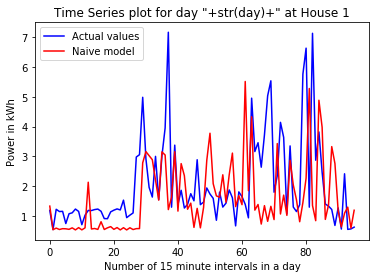

Mean_Absolute_Error for prediction using Naive model: 1.80034


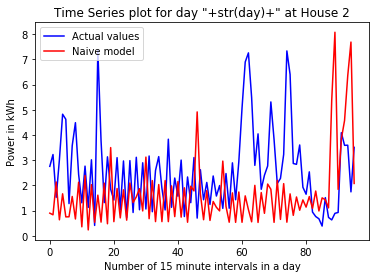

Mean_Absolute_Error for prediction using Naive model: 1.81639


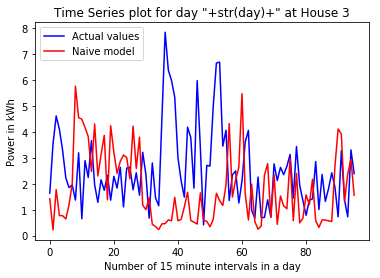

Mean_Absolute_Error for prediction using Naive model: 0.86567


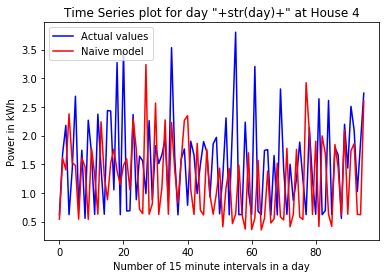

Mean_Absolute_Error for prediction using Naive model: 1.26470


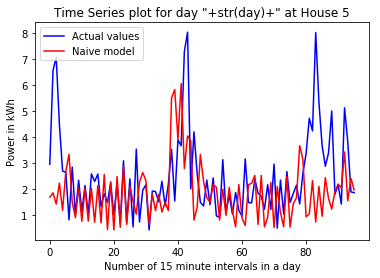

Mean_Absolute_Error for prediction using Naive model: 1.42304


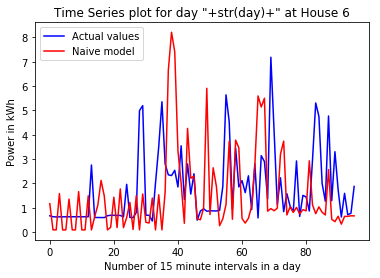

Mean_Absolute_Error for prediction using Naive model: 1.31761


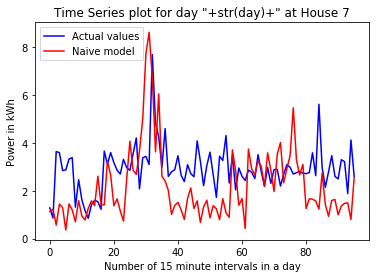

Mean_Absolute_Error for prediction using Naive model: 1.63244


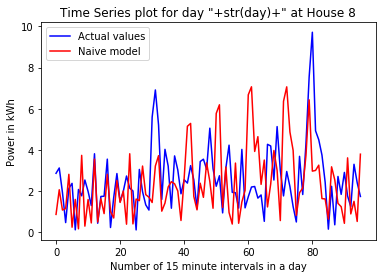

Mean_Absolute_Error for prediction using Naive model: 1.23207


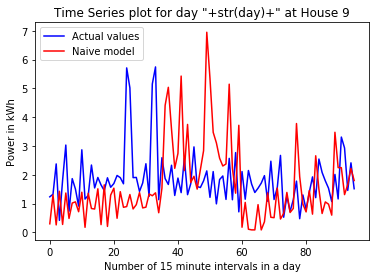

Mean_Absolute_Error for prediction using Naive model: 1.27575


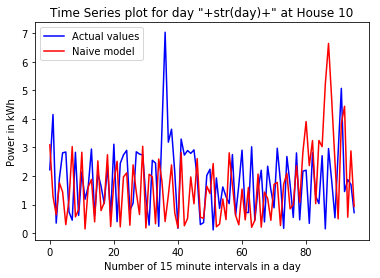

In [11]:
#Naive model

def Naive_Model(X):
    return X[-96:]

def Mean_Absolute_Error(x, y):
    return sum([abs(x[i] - y[i]) for i in range(len(y))])/(len(y) * 1.0)

day_value = 364
interval_count = day_value * 96

k = 1
for house_data in all_house_data:
    column = house_data.columns[0]
    X_range = np.array([i for i in range(96)])
    X_train = np.array(house_data[column].values[:interval_count])
    Y_actual = np.array(house_data[column].values[interval_count:interval_count+96])
    Y_predicted_naive_model = np.array(Naive_Model(X_train))
    print("Mean_Absolute_Error for prediction using Naive model: %.5f" % Mean_Absolute_Error(Y_actual, Y_predicted_naive_model))
    plotvalues(X_range, Y_actual, Y_predicted_naive_model, k, "Actual values", "Naive model", 364)
    k += 1


Mean Absolute Error : 1.61194


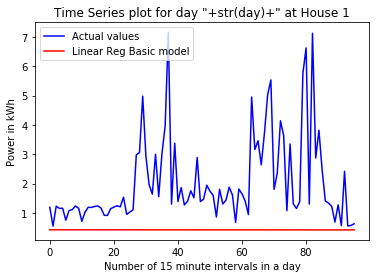

Mean Absolute Error : 1.77020


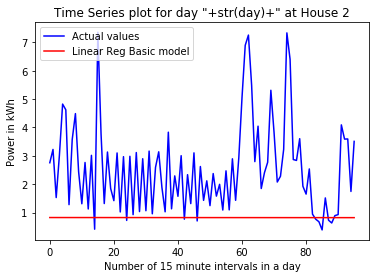

Mean Absolute Error : 2.23507


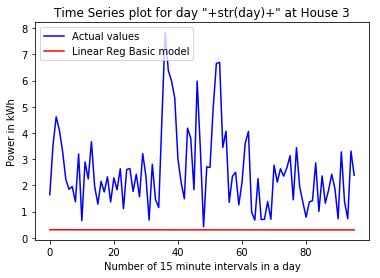

Mean Absolute Error : 1.18545


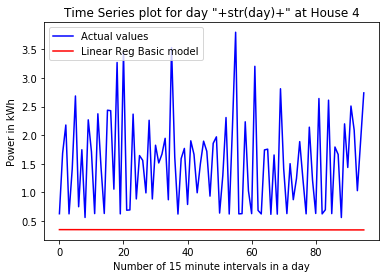

Mean Absolute Error : 2.05844


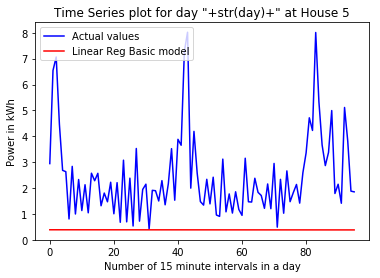

Mean Absolute Error : 1.27491


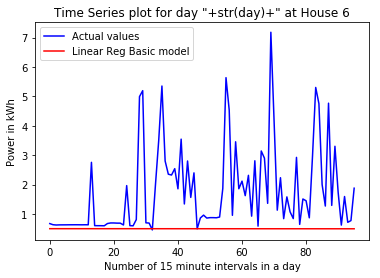

Mean Absolute Error : 1.92995


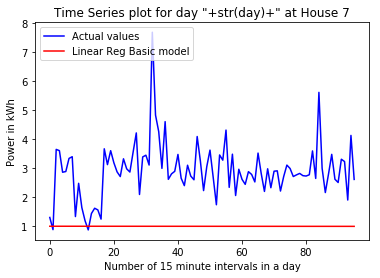

Mean Absolute Error : 2.02113


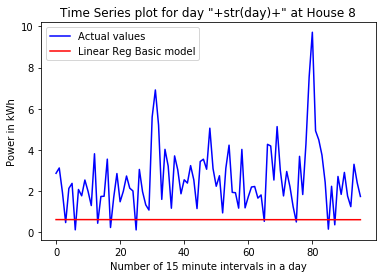

Mean Absolute Error : 1.32256


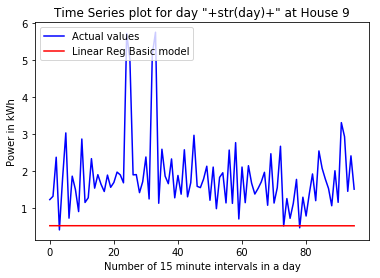

Mean Absolute Error : 1.75306


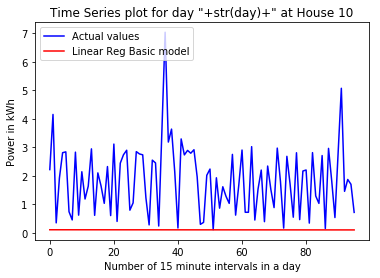

In [12]:
def lin_reg_basic(house_data):
    X_test = house_data[column].values[interval_count:interval_count+96]
    #Linear Regression without basic features
    linear_regression = LinearRegression()
    final_columns = house_data.columns

    linear_reg_train_X = np.array([i for i in range(1,len(X_train)+1)]).reshape(-1, 1)
    linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
    linear_reg_test_X = np.array([len(X_train)+i for i in range(1,len(X_test)+1)]).reshape(-1, 1)
    linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

    linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
    linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
    print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))
    return linear_reg_predicted_Y
    
k = 1
for house_data in all_house_data:
    Y_predicted_linear_basic_model = lin_reg_basic(house_data)
    column = house_data.columns[0]
    X_range = np.array([i for i in range(96)])
    #X_train = np.array(house_data[column].values[:interval_count])
    Y_actual = np.array(house_data[column].values[interval_count:interval_count+96])
    plotvalues(X_range, Y_actual, Y_predicted_linear_basic_model, k, "Actual values", "Linear Reg Basic model", 364)
    k += 1


Mean Absolute Error : 1.67678


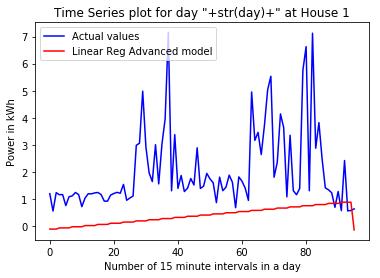

Mean Absolute Error : 1.89357


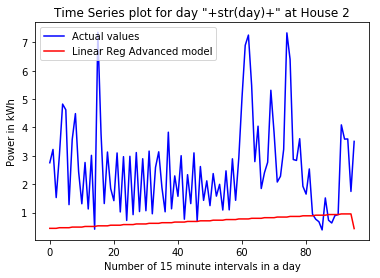

Mean Absolute Error : 2.27831


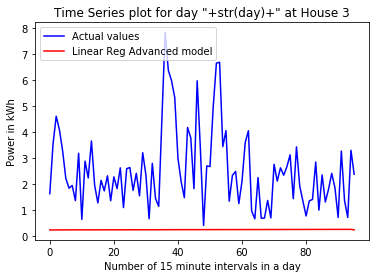

Mean Absolute Error : 1.25478


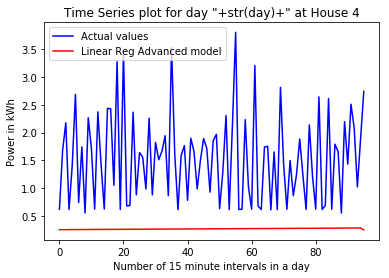

Mean Absolute Error : 2.09024


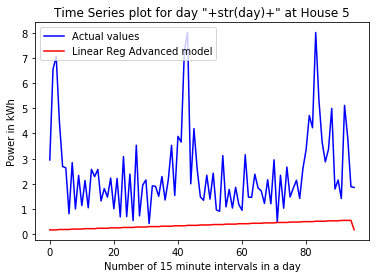

Mean Absolute Error : 1.35920


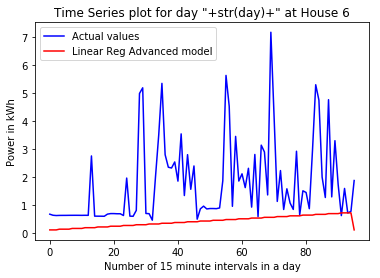

Mean Absolute Error : 1.97476


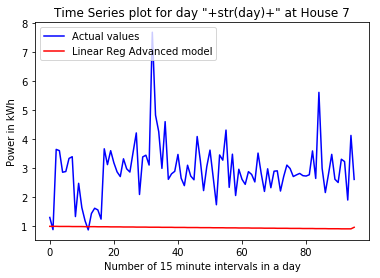

Mean Absolute Error : 2.09084


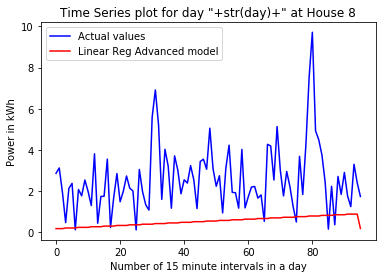

Mean Absolute Error : 1.41073


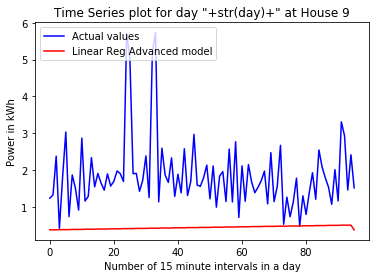

Mean Absolute Error : 1.79078


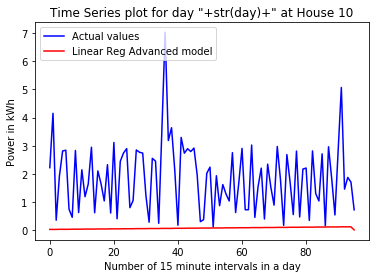

In [13]:
def lin_reg_adv(house_data):
    day_value = 364
    interval_count = day_value * 96
    column = house_data.columns[0]
    X_test = house_data[column].values[interval_count:interval_count+96]
    #Linear Regression with additional features
    day_value = 364
    interval_count = day_value * 96
    column = house_data.columns[0]
    linear_regression = LinearRegression()
    final_columns = house_data.columns[2:]

    linear_reg_train_X = house_data[final_columns][:interval_count]
    linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
    linear_reg_test_X = house_data[final_columns][interval_count:interval_count+96]
    linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

    linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
    linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
    print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))
    return linear_reg_predicted_Y


day_value = 364
interval_count = day_value * 96
k = 1
for house_data in all_house_data:
    Y_predicted_linear_adv_model = lin_reg_adv(house_data)
    column = house_data.columns[0]
    X_range = np.array([i for i in range(96)])
    #X_train = np.array(house_data[column].values[:interval_count])
    Y_actual = np.array(house_data[column].values[interval_count:interval_count+96])
    plotvalues(X_range, Y_actual, Y_predicted_linear_adv_model, k, "Actual values", "Linear Reg Advanced model", 364)
    k += 1

In [ ]:
from fbprophet import Prophet

def prophet_model(house_data):
    day_value = 364
    interval_count = day_value * 96
    df = pd.DataFrame({"ds":house_data["time_stamp"].values})
    df['y'] = house_data['load_demand']
    df.reset_index(drop=False,inplace=True)

    day_value = 364
    interval_count = day_value * 96

    fp_train_X = df[:interval_count]
    fp_train_Y = np.array(df['y'].values[:interval_count])
    fp_test_X = df[interval_count:interval_count+96]
    fp_test_Y = np.array(df['y'].values[interval_count:interval_count+96])

    # creating holiday list
    fed_holiday = pd.DataFrame({"ds":house_data["time_stamp"].values})
    fed_holiday['holiday'] = house_data['holiday']
    fed_holiday = fed_holiday[fed_holiday['holiday'] == 1]
    fed_holiday['holiday'] = fed_holiday.apply(lambda row: 'holiday', axis=1)

    m = Prophet(yearly_seasonality=True, holidays=fed_holiday)
    m.fit(fp_train_X)

    future = m.make_future_dataframe(periods=60*24, freq='min')
    future = future[::-15][:96]
    future = future[::-1]
    #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    result_y = m.predict(future)
    print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(fp_test_Y, result_y['yhat']))
    return result_y['yhat']

k = 1
for house_data in all_house_data:
    Y_predicted_prophet_model = prophet_model(house_data)
    column = house_data.columns[0]
    X_range = np.array([i for i in range(96)])
    #X_train = np.array(house_data[column].values[:interval_count])
    Y_actual = np.array(house_data[column].values[interval_count:interval_count+96])
    plotvalues(X_range, Y_actual, Y_predicted_prophet_model, k, "Actual values", "Prophet model", 364)
    k += 1

In [ ]:
import warnings
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

def sarima_model(house_data):
    X_train = np.array(house_data[column].values[:interval_count])

    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

    '''
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(X_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    '''
    
    model = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    #model = SARIMAX(X_train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)
    predicted_Y = model_fit.predict(len(X_train), len(X_train)+95)
    print(len(linear_reg_predicted_Y), len(X_test))
    print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, predicted_Y))
    return predicted_Y

k = 1
for house_data in all_house_data:
    if k >2:
        break
    sarima_model_out = sarima_model(house_data)
    column = house_data.columns[0]
    X_range = np.array([i for i in range(96)])
    
    Y_actual = np.array(house_data[column].values[interval_count:interval_count+96])
    plotvalues(X_range, Y_actual, sarima_model_out, k, "Actual values", "Sarima model", 364)
    k += 1

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
####